The goal of this notebook is: input to the notebook should be the filtered version of the AMT task
1. Get basic statistics of the annotated data.
2. Save invalid/valid questions into seperate files.
3. Rank worker generated question similarity, then annotate manually.
4. Save worker generated questions without duplication.
5. Run grammar correction using grammarly, then save both original worker questions and correct questions. 

In [649]:
import pandas as pd
import json
import nltk
from matplotlib import pyplot as plt
import numpy as np
import utils

In [650]:
def return_response_dataframe(path_with_filename):
    df = pd.read_csv(path_with_filename,header='infer')
    original_num = df.shape[0]
    df = df[df.Reject.isnull()]
    df = df[df.AssignmentStatus != 'Rejected'][['Input.context_sentence','Input.question','Answer.taskAnswers']]
    after_filter = df.shape[0]
    print(after_filter/original_num, 'percent of the data get accepted.')
    df.columns = ['context_sentence','question','answer_json']
    df['answer_json'] = df['answer_json'].str[1:-1]
    df['answer_json'] = df['answer_json'].apply(lambda x: json.loads(x))
    df['in_context'] = df['answer_json'].apply(lambda x: 1 if x['in_context']['yes'] else 0)
    df['valid_question'] = df['answer_json'].apply(lambda x: 1 if x['rating']['yes'] else 0)
    df['invalid_question'] = df['answer_json'].apply(lambda x:  1 if x['rating']['no'] else 0)
    df['worker_answer'] = df['answer_json'].apply(lambda x: x['worker_answer'] if 'worker_answer' in x.keys() else "")
    df['worker_question'] = df['answer_json'].apply(lambda x: x['worker_question'] if 'worker_question' in x.keys() else "")
    df = df.drop(columns=['answer_json'])
    return df

In [651]:
# update the path
# path = './round2_0504job'
# df = return_response_dataframe(path+'/Batch_4430919_batch_results_rejected.csv') 
path = './round2_0506job'
df = return_response_dataframe(path+'/Batch_4433316_batch_results_rejected.csv') 
# update the path
# path = './round1_combined_jobs/0330_0405_job_combined/'
# df = return_response_dataframe(path+'/combined_rejected.csv') 
# path = './round1_combined_jobs/'
# df = return_response_dataframe(path+'0409_rejected.csv') 
# number of rows
pd.set_option('display.max_rows', df.shape[0]+1)
pd.set_option('display.max_colwidth', -1)
accepted_annotations_count = df.shape[0]   

0.7802197802197802 percent of the data get accepted.


<ipython-input-651-195c5a12046b>:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Filter for answer in context
It should be the same as before, if using the same functions to do the filtering

In [652]:
df['context_sentence'] = df['context_sentence'].str.lower()
df['worker_answer'] = df['worker_answer'].str.lower()

df['context_sentence_'] = df['context_sentence'].apply(utils.lemmatize_text).apply(' '.join)
df['worker_answer_'] = df['worker_answer'].apply(utils.lemmatize_text)

df['answer_in_context_sentence'] = df.apply(lambda x: utils.word_found(x['worker_answer_'], x['context_sentence_']), axis=1)
df['answer_in_context_instruction'] = df.apply(lambda x: utils.word_found_instruction(x['worker_answer_']),
                                                axis=1)
df = df[df['answer_in_context_sentence']==False]
df = df[df['answer_in_context_instruction']==False].drop(columns=['context_sentence_','worker_answer_','answer_in_context_sentence'])

In [653]:
# count
incontext_removal_count = df.shape[0]

In [654]:
df_orig = df[['context_sentence','question']]
distinct_sen_ques = df[['context_sentence','question']].drop_duplicates().shape[0]

## Filter rows for which atleast 2 worker are in agreement. 
valid/invalid and in context.

In [655]:
df_ = df[['context_sentence','question', 'in_context', 'valid_question','invalid_question']]\
.groupby(['context_sentence','question']).agg('sum')

df_['valid_question_count'] = df_['valid_question'].apply(lambda x: x if x>=2 else 0)
df_['invalid_question_count'] = df_['invalid_question'].apply(lambda x: x if x>=2 else 0)

df_['valid_question_marker'] = df_['valid_question_count'].apply(lambda x: 1 if x>=2 else 0)
df_['invalid_question_marker'] = df_['invalid_question_count'].apply(lambda x: 1 if x>=2 else 0)

df_['in_context_marker'] = df_['in_context'].apply(lambda x: 1 if (x>=2 or x==0) else 0)

In [656]:
df_= df_[((df_['valid_question_marker']==1) | (df_['invalid_question_marker']==1)) & df_['in_context_marker']]
df_.shape

(57, 8)

In [657]:
valid_num = df_[(df_['valid_question_marker']==1) & (df_['invalid_question_marker']==0) & (df_['in_context']==0)].\
groupby(['context_sentence','question']).agg('sum').shape[0]
print(valid_num)

50


In [658]:
invalid_num = df_[((df_['invalid_question_marker']==1) & (df_['valid_question_marker']==0) & (df_['in_context_marker']==1)) | ((df_['valid_question_marker']==1) & (df_['invalid_question_marker']==0) & (df_['in_context']>=2))].groupby(['context_sentence','question']).agg('sum').shape[0]
print(invalid_num)

6


In [659]:
# one question has two annotations valid and two annotations invalid.

## Print Valid Questions

In [660]:
new_df = df.merge(df_, how='inner', left_on=['context_sentence','question'], right_on=['context_sentence','question'])

In [661]:
df_valid=new_df[(new_df['valid_question_marker']==1) & (new_df['invalid_question_marker']==0) & (new_df['in_context_y']==0)]
df_valid = df_valid.drop(columns=['invalid_question_count','valid_question_count', 'answer_in_context_instruction', 'valid_question_y', 'invalid_question_y'])

In [662]:
print(df_valid.columns)

Index(['context_sentence', 'question', 'in_context_x', 'valid_question_x',
       'invalid_question_x', 'worker_answer', 'worker_question',
       'in_context_y', 'valid_question_marker', 'invalid_question_marker',
       'in_context_marker'],
      dtype='object')


In [663]:
# drop annotations that disagrees with the majority.
values = df_valid.values.tolist()
valid_answer_list = []
for v in values:
    assert v[8] == 1 
    assert v[9] == 0
    assert v[7] == 0
    if v[2] == 0 and v[3] == 1:
        valid_answer_list.append(v)
print(len(valid_answer_list))

135


In [664]:
df_valid_annotations = pd.DataFrame(valid_answer_list, columns =df_valid.columns)
valid_count = df_valid_annotations.shape[0]
valid_distinct = df_valid_annotations[['context_sentence','question']].drop_duplicates().shape[0]

## Print Invalid Questions

In [665]:
df_invalid=new_df[((new_df['invalid_question_marker']==1) & (new_df['valid_question_marker']==0) & (new_df['in_context_marker']==1))\
              | ((new_df['valid_question_marker']==1) & (new_df['invalid_question_marker']==0) & (new_df['in_context_y']>=2))]
df_invalid = df_invalid.drop(columns=['invalid_question_count','valid_question_count', 'answer_in_context_instruction', 'valid_question_y', 'invalid_question_y'])

In [666]:
print(df_invalid.columns)

Index(['context_sentence', 'question', 'in_context_x', 'valid_question_x',
       'invalid_question_x', 'worker_answer', 'worker_question',
       'in_context_y', 'valid_question_marker', 'invalid_question_marker',
       'in_context_marker'],
      dtype='object')


In [667]:
# drop annotations that disagrees with the majority.
values = df_invalid.values.tolist()
invalid_answer_list = []
for v in values:
    # two conditions: valid question but answer in context
    if v[8]==1 and v[9] == 0 and v[7]>=2:
        if v[3] == 1 and v[4] == 0 and v[2] == 1:
            invalid_answer_list.append(v)
    # invalid question
    elif v[8]==0 and v[9]==1 and v[10] == 1:
        if v[4] == 1 and v[3] == 0:
            invalid_answer_list.append(v)
    else:
        print('Not considered in invalid case')
print(len(invalid_answer_list))

13


In [668]:
df_invalid_annotations = pd.DataFrame(invalid_answer_list, columns =df_invalid.columns)
invalid_annotation = df_invalid_annotations.shape[0]
invalid_distinct = df_invalid_annotations[['context_sentence']].drop_duplicates().shape[0]

# Stats

In [669]:
print('Accepted annotations:', accepted_annotations_count)
print('Distinct Context-Question pair:', distinct_sen_ques)
print('--------------------------------------------------------------------------------------------------------')
print('Count after removing in-context answers (should be the same as accepted annotations):',incontext_removal_count)
print('--------------------------------------------------------------------------------------------------------')
print('Distinct Context-Question pair with worker agreement on validity/invalidity:', valid_distinct+invalid_distinct)
print('--------------------------------------------------------------------------------------------------------')
print('Distinct Valid Context-Question pair:',valid_distinct)
print('Valid Annotations:', valid_count)
print('--------------------------------------------------------------------------------------------------------')
print('Distinct Invalid Context-Question pair:',invalid_distinct)
print('Worker generated context and question pair for invalid questions:',invalid_annotation)
print('--------------------------------------------------------------------------------------------------------')
print()

Accepted annotations: 213
Distinct Context-Question pair: 71
--------------------------------------------------------------------------------------------------------
Count after removing in-context answers (should be the same as accepted annotations): 213
--------------------------------------------------------------------------------------------------------
Distinct Context-Question pair with worker agreement on validity/invalidity: 55
--------------------------------------------------------------------------------------------------------
Distinct Valid Context-Question pair: 50
Valid Annotations: 135
--------------------------------------------------------------------------------------------------------
Distinct Invalid Context-Question pair: 5
Worker generated context and question pair for invalid questions: 13
--------------------------------------------------------------------------------------------------------



<AxesSubplot:title={'center':'Plot of valid questions per context sentence'}, xlabel='Valid question count', ylabel='No. of context sentences'>

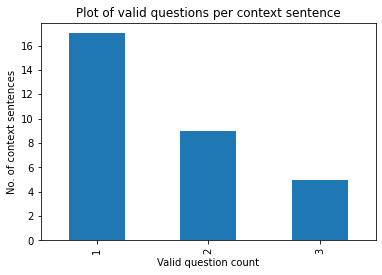

In [670]:
df_hist = df_valid_annotations[['context_sentence','question']].drop_duplicates().groupby(['context_sentence']).agg(['count'])

plt.title('Plot of valid questions per context sentence')
plt.xlabel("Valid question count")
plt.ylabel("No. of context sentences")
df_hist[('question', 'count')].value_counts().plot.bar()

<AxesSubplot:title={'center':'Plot of number of annotations per context sentence/question pair'}, xlabel='Valid annotation count', ylabel='No. of context sentences'>

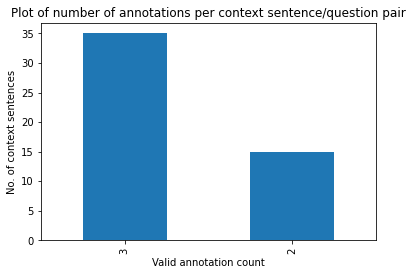

In [671]:
df_hist = df_valid_annotations[['context_sentence','question']].groupby(['question']).agg(['count'])

plt.title('Plot of number of annotations per context sentence/question pair')
plt.xlabel("Valid annotation count")
plt.ylabel("No. of context sentences")
df_hist[('context_sentence', 'count')].value_counts().plot.bar()

<AxesSubplot:title={'center':'Plot of number of annotations per context sentence/question pair'}, xlabel='Invalid annotation count', ylabel='No. of context sentences'>

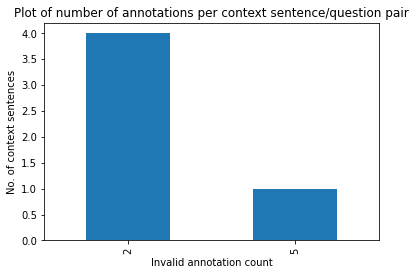

In [672]:
df_hist = df_invalid_annotations[['context_sentence','question']].groupby(['context_sentence']).agg(['count'])

plt.title('Plot of number of annotations per context sentence/question pair')
plt.xlabel("Invalid annotation count")
plt.ylabel("No. of context sentences")
df_hist[('question', 'count')].value_counts().plot.bar()

Save the files

In [673]:
# save valid questions with grammar correction, only for round1
# round 2 questions have been corrected
for q in df_valid_annotations['question'].tolist():
    print(q)

What happened to the journalist?
What happened to the journalist?
What happened to the journalist?
Why is the dog putting snow in his mouth?
Why is the dog putting snow in his mouth?
Why is the dog putting snow in his mouth?
Where are the icons?
Where are the icons?
Which type of music can be used while decorating the tree?
Which type of music can be used while decorating the tree?
Which type of music can be used while decorating the tree?
Where is the guitar pick?
Where is the guitar pick?
What does the soldier use on the wound?
What does the soldier use on the wound?
What does the soldier use on the wound?
Why does the actor pose for photos?
Why does the actor pose for photos?
Why does the actor pose for photos?
How do bike helmets help prevent death and serious injury?
How do bike helmets help prevent death and serious injury?
How do bike helmets help prevent death and serious injury?
Who is cooking the vegetables in a pan?
Who is cooking the vegetables in a pan?
Who is cooking the 

In [369]:
# next, open grammarly
# copy the above text
# correc the sentences, then copy the corrected one back

In [563]:
# group1 & 2 (r1)
# corrected_one = """Why do I usually take scooters?
# Why do I usually take scooters?
# Why does businessman usually call on phones?
# Why does businessman usually call on phones?
# Why does a business usually introduce in versions?
# Why does a business usually introduce in versions?
# When does a person usually attend screens?
# When does a person usually attend screens?
# When does a person usually attend screens?
# Why does a person usually browse windows?
# Why does a person usually browse windows?
# How does a person usually shout in a slogan?
# How does a person usually shout in a slogan?
# Where does a person usually kiss on figurines?
# Where does a person usually kiss on figurines?
# Where does a person usually kiss on figurines?
# When does a person usually harvest fields?
# When does a person usually harvest fields?
# When does a person usually harvest fields?
# Why does a person usually advertise release?
# Why does a person usually advertise release?
# Why does a person usually advertise release?
# When does politician usually attend dinners?
# When does politician usually attend dinners?
# When does politician usually attend dinners?
# Where does a location usually launch on missions?
# Where does a location usually launch on missions?
# How does a person usually dance to music?
# How does a person usually dance to music?
# Where does a person usually play at roulette?
# Where does a person usually play at roulette?
# Where does a person usually play at roulette?
# How does a person usually examine the fuselage?
# How does a person usually examine the fuselage?
# When does a person usually attend a party?
# When does a person usually attend a party?"""

In [593]:
# group 3 (r1)
corrected_one = """Where does a business usually host an event?
Where does a business usually host an event?
Who usually fills bubble?
Who usually fills bubble?
How does a family usually decorate the tree?
How does a family usually decorate the tree?
Where does a person usually attend the party?
Where does a person usually attend the party?
How do passengers usually cross-bay?
How do passengers usually cross-bay?"""

In [594]:
df_valid_annotations.columns

Index(['context_sentence', 'question', 'in_context_x', 'valid_question_x',
       'invalid_question_x', 'worker_answer', 'worker_question',
       'in_context_y', 'valid_question_marker', 'invalid_question_marker',
       'in_context_marker'],
      dtype='object')

In [595]:
post_grammar_correction_list = []
my_list = df_valid_annotations.values.tolist()
post_sentence = corrected_one.split('\n')
assert len(post_sentence) == len(my_list)
for i in range(len(my_list)):
    data = my_list[i]
    post_grammar_correction_list.append((data[0], data[1], post_sentence[i], data[5]))

In [596]:
# this is only done for the first round questions
# df_valid_correct = pd.DataFrame(post_grammar_correction_list, columns =['context_sentence', 'grammar_incorrected_question', 'question', 'worker_answer'])
# df_valid_correct.to_csv(path+'/corrected_valid_questions.csv', index=False)

In [674]:
# this is done for second round questions
df_valid_annotations[['context_sentence','question','worker_answer']].to_csv(path+'/valid_questions.csv', index=False)

In [675]:
df_invalid_annotations[['context_sentence','question','worker_question','worker_answer']].to_csv(path+'/invalid_questions.csv', index=False)

# If the analysis is in first round: find question similarity in worker questions
otherwise, skip

In [463]:
import string
import re
from nltk.util import ngrams
import itertools
from collections import defaultdict

def get_1g(txt):
    return get_tuples_nosentences(txt, 1)


def get_2g(txt):
    return get_tuples_nosentences(txt, 2)


def get_3g(txt):
    return get_tuples_nosentences(txt, 3)


def get_tuples_nosentences(txt, n):
    re_stripper_alpha = re.compile('[^a-zA-Z]+')
    if not txt: return None
    ng = ngrams(re_stripper_alpha.sub(' ', txt).split(), n)
    return list(ng)

def standardize_string(words):
    text = []
    for word in words.split():
        text.append(word.lower())
    return ' '.join(text)[:-1]

In [464]:
df_ = pd.read_csv(path+'/invalid_questions.csv',header='infer')[['context_sentence','worker_question']]

# converting to lower case and removing question mark
df_['worker_question_'] = df_['worker_question'].apply(standardize_string).apply(utils.lemmatize_text_keep_sw).apply(' '.join)
# df_

In [465]:
df_as_dict = df_.to_dict('records')
context_dict=defaultdict(list)

for row in df_as_dict:
    context_dict[row['context_sentence']].append(row['worker_question_'])

context_dict=dict(context_dict)
context_question_pair_mapping={}
for context in context_dict:
    context_question_pair_mapping[context]=list(itertools.combinations(context_dict[context], 2))

In [466]:
pair_context_ratios=defaultdict(dict)
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

for context in context_question_pair_mapping:
    for pairs in context_question_pair_mapping[context]:
            sentence1_one_gram = get_1g(pairs[0])
            sentence1_two_gram = get_2g(pairs[0])
            sentence1_three_gram = get_3g(pairs[0])
            sentence2_one_gram = get_1g(pairs[1])
            sentence2_two_gram = get_2g(pairs[1])
            sentence2_three_gram = get_3g(pairs[1])
            same_first_word = (pairs[0].split(" ")[0] == pairs[1].split(" ")[0])
            one_gram_union = sentence1_one_gram + sentence2_one_gram
            two_gram_union = sentence1_two_gram + sentence2_two_gram
            three_gram_union = sentence1_three_gram + sentence2_three_gram
            one_gram_intersection = intersection(sentence1_one_gram, sentence2_one_gram)
            two_gram_intersection = intersection(sentence1_two_gram, sentence2_two_gram)
            three_gram_intersection = intersection(sentence1_three_gram, sentence2_three_gram)
            one_gram_ratio = len(one_gram_intersection)/len(one_gram_union)
            two_gram_ratio = len(two_gram_intersection)/len(two_gram_union)
            three_gram_ratio = len(three_gram_intersection)/len(three_gram_union)
            pair_context_ratios[pairs]={'context':context, 'one_g_ratio':one_gram_ratio, 'two_g_ratio':two_gram_ratio, 'three_g_ratio':three_gram_ratio, 'same_first_word':same_first_word}

dict_list = []
for pair in pair_context_ratios:
    dict_list.append({"context sentence": pair_context_ratios[pair]['context'],
                      "q1": pair[0],
                      "q2": pair[1],
                      "same first word": pair_context_ratios[pair]['same_first_word'],
                      "1-gram ratio": pair_context_ratios[pair]['one_g_ratio'],
                      "2-gram ratio": pair_context_ratios[pair]['two_g_ratio'],
                      "3-gram ratio": pair_context_ratios[pair]['three_g_ratio']} )
df=pd.DataFrame(dict_list)

In [467]:
df_ques_map = df_[['worker_question','worker_question_']]

df_same_w = df[df['same first word']==True]
df_same_w = df_same_w.merge(df_ques_map, left_on='q1', right_on='worker_question_').rename(columns={'worker_question': 'question 1'})
df_same_w = df_same_w.merge(df_ques_map, left_on='q2', right_on='worker_question_').rename(columns={'worker_question': 'question 2'})
df_same_w = df_same_w[['context sentence','question 1','question 2','1-gram ratio','2-gram ratio','3-gram ratio']]
print('Worker questions pairs with same 1st word:',df_same_w.shape[0])
df_same_w.sort_values(by=['2-gram ratio','3-gram ratio', '1-gram ratio'], ascending=False).reset_index(drop=True)

# group1 & group2
# duplicates = {0,1,2,3,4,5,10,11,12,13,14,16,17}, count = 13

# group3
# duplicates = {0,1,3,4,6,7,10,13,14,15,19}, count = 11

Worker questions pairs with same 1st word: 22


,context sentence,question 1,question 2,1-gram ratio,2-gram ratio,3-gram ratio
0,a gymnast slips on a cube of ice as he attempts to stand on the mat causing him to break his foot.,why was the ice on the mat?,Why was ice on the mat?,0.461538,0.363636,0.222222
1,two men working on a machine wearing hard hats.,Why do the men working on machine wear hard hats?,Why do the men wear hard hats?,0.411765,0.333333,0.230769
2,illustration of an isolated guitar pick with a rocket,Where is the guitar pick?,Where is the rocket?,0.333333,0.285714,0.200000
3,the soldier teaches the student how to treat wounds.,What does the soldier use on the wound?,What does the soldier teach?,0.307692,0.272727,0.222222
4,"furrowing her brow, someone looks around at the other people in the boat who avert their gaze.",Where is the boat going?,where was the boat going?,0.400000,0.250000,0.166667
5,set of flat round icons with diagrams on the gray background vector,What are the icons used for?,What colr are the icons?,0.363636,0.222222,0.142857
6,the dog went on a walk and kept putting the snow in his mouth.,Why is the dog putting snow in his mouth?,Why do dogs put snow in their mouth?,0.352941,0.200000,0.153846
7,two men working on a machine wearing hard hats.,Why do the men wear hard hats?,Why do working men wear hats?,0.384615,0.181818,0.000000
8,sailors assigned man the rails as the ship passes person,What do sailors usually do?,What do sailors need to have to pass the rails with the ship?,0.166667,0.125000,0.071429
9,fashion model donned ensembles on the runway at show including this ethereal creation .,Why is the actor donning ensembles?,Why does model usually don ensemble?,0.250000,0.100000,0.000000


In [468]:
df_diff_w = df[df['same first word']==False]
df_diff_w = df_diff_w.merge(df_ques_map, left_on='q1', right_on='worker_question_').rename(columns={'worker_question': 'question 1'})
df_diff_w = df_diff_w.merge(df_ques_map, left_on='q2', right_on='worker_question_').rename(columns={'worker_question': 'question 2'})
df_diff_w = df_diff_w[['context sentence','question 1','question 2','1-gram ratio','2-gram ratio','3-gram ratio']]
print('Worker questions pairs with different 1st word:',df_diff_w.shape[0])
df_diff_w.sort_values(by=['2-gram ratio','3-gram ratio', '1-gram ratio'], ascending=False).reset_index(drop=True)


# group1 & group2
# no duplicates 

# group3 
# duplicates and bad questions = {4,6,9,22,28,29}, count = 11

Worker questions pairs with different 1st word: 48


,context sentence,question 1,question 2,1-gram ratio,2-gram ratio,3-gram ratio
0,set of flat round icons with diagrams on the gray background vector,Where are the icons?,What colr are the icons?,0.333333,0.285714,0.200000
1,biological species took some photos of the owl preening his feathers .,Where is the owl sitting?,Why is the owl preening?,0.300000,0.250000,0.166667
2,set of flat round icons with diagrams on the gray background vector,Where are the icons?,What are the icons used for?,0.300000,0.250000,0.166667
3,a gymnast slips on a cube of ice as he attempts to stand on the mat causing him to break his foot.,why was the ice on the mat?,What was the gymnast doing on the mat?,0.266667,0.230769,0.090909
4,actor poses for photos at the event honoring comedian,Which actor posed for pictures?,Why does actor pose for photos?,0.272727,0.222222,0.142857
5,the boy keep calm breathes the air and kick the ball with his foot to make the goal,What sport was the boy playing?,Where is the boy playing?,0.272727,0.222222,0.142857
6,actor in couture at the premiere .,Where was the premiere held?,what movie was the premiere for?,0.272727,0.222222,0.142857
7,"after you ride the horse, you must hit the ball at least 100 yards.",What is used to hit the ball?,How do you hit the ball?,0.230769,0.181818,0.111111
8,a gymnast slips on a cube of ice as he attempts to stand on the mat causing him to break his foot.,What was the gymnast doing on the mat?,Why was ice on the mat?,0.285714,0.166667,0.100000
9,a guy is seasoning some tomatoes to make a salad.,Why is the guy making a salad?,What is the guy seasoning tomatoes with?,0.214286,0.166667,0.100000


# Save worker generated questions without duplication

In [469]:
df = pd.read_csv(path+'/invalid_questions.csv',header='infer')
df.columns

Index(['context_sentence', 'question', 'worker_question', 'worker_answer'], dtype='object')

In [383]:
# group1 & group2
# duplicated_questions = [
#     "Where is the printer located?",
#     "Where is the boy throwing darts?",
#     "Why was the woman taking pictures of the camels?",
#     "How did his spinal cord get the injury?",
#     "How does the farmer know if his crops have grown?",
#     "What is featured in the spring collection?",
#     "Why does he want to distract the Japanese?",
#     "What is the goldfish doing?",
#     "what creature is the design",
#     "What is the monster pointing to?",
#     "Where do I find shirts",
#     "How does this transitional design feature on white cabinets with black granite countertops?",
#     "What does a person usually wear during the festival?",
#     "What are the two main colors of the Christmas wreath?",
#     "where does a politician discuss shooting with top officials?",
#     "Where does the team usually perform?"
# ]

In [470]:
# group3 
duplicated_questions = [
    "Why was ice on the mat?",
    "Why do the men working on machine wear hard hats?",
    "What does the soldier teach?",
    "Where is the boat going?",
    "where was the boat going?",
    "Why is the dog putting snow in his mouth?",
    "Why do working men wear hats?",
    "Why is he preparing salad?",
    "Why does the woman apply lotion to her face?",
    "Why is the woman adjusting the resistance?",
    "What is the name of one of the nominees?",
    "Which actor posed for pictures?",
    "what movie was the premiere for?",
    "What is the guy seasoning tomatoes with?",
    "Where is the dog running to?",
    "What music should we play in the background?",
    "Who is taking the pictures?"
]

In [471]:
values = df.values.tolist()
my_list = []
for v in values:
    if v[2] in duplicated_questions:
        pass
    else:
        my_list.append(v)


In [472]:
# print the questions to pass into grammarly.
for d in my_list:
    print(d[2])

What does the soldier use on the wound? 
Why do the men wear hard hats? 
Why are the vegetables being cooked? 
Who is cooking the vegetables in a pan?
Why is the actor donning ensembles? 
Why does model usually don ensemble?
Why does she furrow her brow? 
Who is taking the pictures? 
Why does actor pose for photos?
Why is the guy making a salad? 
Why does the armed force have weapons? 
Why do armed forces go for training?
Where is the foot patrol being conducted?
why was the ice on the mat?
What was the gymnast doing on the mat?
What do sailors usually do?
What do sailors need to have to pass the rails with the ship?
Why is the ship passing the person? 
Why are the cords plugged in? 
Where is the white electric outlet located?
what color is the wall?
What do politicians need when announcing a candidacy?
How does a politician announce they are planning to run for the nomination?
Where did the politician announce his bid?
Where is the guitar pick?
What is a guitar pick used for? 
Where i

In [474]:
# group3
post_grammarly = """What does the soldier use on the wound? 
Why do the men wear hard hats? 
Why are the vegetables being cooked? 
Who is cooking the vegetables in a pan?
Why is the actor donning ensembles? 
Why does the model usually don ensemble?
Why does she furrow her brow? 
Who is taking the pictures? 
Why does the actor pose for photos?
Why is the guy making a salad? 
Why does the armed force have weapons? 
Why do armed forces go for training?
Where is the foot patrol being conducted?
Why was the ice on the mat?
What was the gymnast doing on the mat?
What do sailors usually do?
What do sailors need to have to pass the rails with the ship?
Why is the ship passing the person? 
Why are the cords plugged in? 
Where is the white electric outlet located?
What color is the wall?
What do politicians need when announcing a candidacy?
How does a politician announce they are planning to run for the nomination?
Where did the politician announce his bid?
Where is the guitar pick?
What is a guitar pick used for? 
Where is the rocket?
Why has the person come to the dentist?
What kind of tool was the dentist use?
What is the name of one of the nominees? 
What are the awards for? 
Where is a mass celebrated? 
Who guides his staff to attend a congregation?
Who usually leads a mass?
What sport was the boy playing?
Where is the boy playing?
WHAT HAPPENED WHEN THE BOY KICKED THE BALL?
Where is the owl sitting?
Why is the owl preening? 
Where is the group of middle-aged people sitting?
What can be done with the notebooks of the group's components?
Why does a dog usually run?
Why do dogs pull on the leash? 
Which type of music can be used while decorating the tree?
What makes tree decoration genuine?
How does my hand shake at the silhouette of the top world?
How to shake hands?
How do bike helmets help prevent death and serious injury?
How come people wear a helmet? 
Where are the icons?
What are the icons used for? 
What color are the icons?
Who has detained the journalist?
What happened to the journalist? 
How do activists participate in protests?
Why do women usually adjust resistance? 
Why is the woman adjusting the resistance? 
Where was the premiere held?
Why is the actor wearing couture? 
What is used to hit the ball? 
How do you hit the ball?
Why do people want a cohesive design? 
Where is the structure?
Why is the dog putting snow in his mouth? 
Where does the dog usually go for a walk?
Why do dogs put snow in their mouth? 
What types of lotion are usually applied to the face?
Why does the woman apply lotion to her face? 
Why does a woman usually apply a lotion?
Why is the actor dressed up? 
When does a person wear a classic black gown? """

In [386]:
# group1 & group2
# post_grammarly = """what is the name of the natural process that features better-adapted organisms outliving others
# What happens to the organism that is not as well suited?
# What color are the strawberries?
# Where do you usually find strawberries in a stack drizzled with chocolate?
# Where is the man wearing boxing gloves practicing?
# Why does the man wear gloves?
# Where is the port?
# What is displayed in the aircraft window?
# Where do I find shirts?
# Where do you usually find clean shirts in your home?
# Where did the meeting between the politician and the top officials happen?
# Which top officials were at the meeting?
# Where does a politician discuss shooting with top officials?
# What is the charger connected to?
# When does the phone get charged?
# What do the ships refuel?
# Why does a ship get replenished?
# What activities happen when crowds gather at night to celebrate?
# When did the soldier die?
# Where is the boy?
# Why are the business people clapping their hands?
# What were the business people wearing?
# How do you save trees?
# What color are the trees?
# Where is planet earth?
# Where is the printer?
# why does she send messages to the printer
# Where small rowboats and yachts moored
# Where was the calm marina?
# When do the yachts plan to go out to sea?
# When will the leaders meet?
# Where was the meeting taking place?
# Where did the religious leader meet the military commander?
# What were the protestors protesting against?
# When does the police usually deploy pepper spray? 
# What makes you scribble?
# Whose address did he scribble on a piece of paper?
# Where in her jumper does he tuck the piece of paper?
# Where does the escalator go?
# Where are the commuters going during rush hour?
# What is the subject of the slogans that the demonstrators are shouting?
# Where is the demonstration being held?
# How will the poster be hung up?
# Why are posters used for advertising films?
# How does a glacier usually carve in the valley?
# When did the glacier carve out the valley?
# Why is the woman taking pictures?
# Where is the woman taking pictures of camels?
# How did he get the injury?
# How did the businessman injury his spinal cord?
# How does the businessman get around with a spinal cord injury?
# Where is the rim of the tire?
# What is the person wiping off of the rim?
# Where did the team dance?
# What event were the football players performing at?
# How does the employee help the sad colleague?
# What mood would an employee be if they were close with their colleagues?
# Why was the colleague sad?
# How does a thing usually feature on cabinets?
# Why are they both different colors?
# What room has the white cabinets and black countertops?
# Where is the smartphone?
# Who is presenting the mock-up?
# What genre of screening is the actor introducing?
# Where does the actor introduce a screening?
# Why was the celebrity slammed?
# Who slammed the celebrity?
# Why does he drop his rifle?
# How far did he have to run?
# What gifts were exchanged?
# Why do the religious leader and politician exchange gifts?
# What does the spring collection usually showcase?
# What did the designer showcase in the installation?
# Where is the advertisement posted?
# Why do people advertise their performances?
# What toppings are on the pizza?
# Who usually displays the pizza?
# Why is the pizza displayed?
# What is the goldfish doing? 
# What happened to the goldfish?
# What is the kid going to do about the water on the floor?
# What does a person usually wear during the festival?
# What do worshippers wear to the festival?
# What are the worshippers doing at the temple?
# What does an isolated microphone shield do?
# Who usually isolated the sword?
# What color was the shield?
# Where is the field located?
# How does the farmer examine the growth?
# What season do people hang up Christmas wreaths?
# What are the two primary colors of the Christmas wreath?
# What types of natural decorations are on the wreath?
# When do the mare and foal get to go into the barn?
# Where is the pasture located?
# Where do horses usually stay that are owned by people?
# What color is the journalist wearing at their wedding reception?
# What does a tv journalist usually do?
# What food does the restaurant service at the reception?
# Why are the firefighters extinguishing the flames?
# How does a person extinguish a fire?"""

In [475]:
post_grammar_correction_list = []
post_sentence = post_grammarly.split('\n')
assert len(post_sentence) == len(my_list)
for i in range(len(my_list)):
    data = my_list[i]
    post_grammar_correction_list.append([data[0], data[1], data[2], post_sentence[i], data[3]])

In [476]:
df_removed_duplicated = pd.DataFrame(post_grammar_correction_list, columns =['context_sentence', 'question', 'worker_question', 'grammar_corrected_worker_question', 'worker_answer'])
invalid_dedup_count = df_removed_duplicated.shape[0]
invalid_dedup_distinct = df_removed_duplicated[['context_sentence']].drop_duplicates().shape[0]
print('Number of questions', invalid_dedup_count)
print('Number of unique context sentences', invalid_dedup_distinct)

Number of questions 71
Number of unique context sentences 32


In [478]:
df_removed_duplicated.columns

Index(['context_sentence', 'question', 'worker_question',
       'grammar_corrected_worker_question', 'worker_answer'],
      dtype='object')

In [479]:
df_removed_duplicated.to_csv(path+'invalid_deduplicated_questions.csv', index=False)

In [480]:
df_removed_duplicated['question'] = df_removed_duplicated['grammar_corrected_worker_question']
df_removed_duplicated[['context_sentence', 'question']].to_csv('./round2_0506job//'+'questions.csv', index=False)